In [8]:
# Cell 1: Imports and Global Configurations (for Jupyter Notebook)
import sys
import os
import random
from PyQt5.QtWidgets import QApplication
from PyQt5.QtGui import QFont, QPainter, QColor, QFontDatabase, QTransform, QImage, QFontMetrics
from PyQt5.QtCore import Qt, QRectF
from IPython.display import Image as IPImage, display # Notebook дотор зураг харуулах

# --- COMMON CONFIGURATIONS ---
# *** ЧУХАЛ: ALL_FONTS_RELATIVE_PATHS дахь замууд нь таны Jupyter Notebook файл байрлаж буй
# *** хавтастай (os.getcwd() командын үр дүн) харьцуулахад ЗӨВ байх ёстой.
ALL_FONTS_RELATIVE_PATHS = [
    '../fonts/Bichimel.ttf',
    '../fonts/mnglwritingotf.ttf',
    '../fonts/UnicodeFontForShare/UnicodeFONT MUNKH/MunkhGalUNICODE/Menk Hawang.ttf',
    '../fonts/UnicodeFontForShare/VertNote/Mongol Bichimel.ttf',
    '../fonts/Chagan.ttf',
    '../fonts/Garchag.ttf',
    '../fonts/Syurga.ttf',
    '../fonts/Urga.ttf',
    '../fonts/UnicodeFontForShare/Microsoft/monbaiti 501.ttf',
    '../fonts/UnicodeFontForShare/UnicodeFONT MUNKH/MunkhGalUNICODE/Menk Qagan.ttf',
    '../fonts/UnicodeFontForShare/UnicodeFONT MUNKH/MunkhGalUNICODE/Menk Sonin.ttf',
    '../fonts/UnicodeFontForShare/VertNote/Mongol Garchig.ttf',
    '../fonts/MONGOLIANSYSTEM0.97.TTF',
    '../fonts/NotoSansMongolian-Regular.ttf', # Noto Sans Mongolian зөв харагдуулахын тулд заримдаа тусгай тохиргоо шаардаж магадгүй.
    '../fonts/UnicodeFontForShare/VertNote/Mongol Web.ttf',
    '../fonts/mngltitleotf.ttf',
    '../fonts/UnicodeFontForShare/UnicodeFONT MUNKH/MunkhGalUNICODE/Menk Garqig.ttf',
]

TEXT_TO_RENDER = "ᠮᠣᠩᠭᠣᠯ"
OUTPUT_IMAGE_FILENAME_PREFIX = "mongol_word_" # Хадгалах зургийн нэрийн эхлэл

BASE_ROTATION_ANGLE_CONFIG = 90
RANDOM_TILT_FULL_RANGE = (-5, 5) # Бага зэргийн налуутай
PADDING_AMOUNT_CONFIG = 25
MIN_SCALING_FACTOR_CONFIG = 1.2 # Хэмжээг бага зэрэг томсгох
MAX_SCALING_FACTOR_CONFIG = 1.5 # Хэт томруулахгүй байх
BASE_FONT_SIZE_CONFIG = 100
TEXT_COLOR_CONFIG = QColor("black")
BACKGROUND_COLOR_CONFIG = QColor("white")

# Зураг хадгалах дэд хавтас
IMAGES_SUBDIR_NAME = "generated_mongol_images"

In [9]:
# Cell 2: Helper Functions (Adapted for Notebook)

def get_absolute_font_paths(notebook_cwd):
    """Converts relative font paths to absolute paths, relative to the notebook's CWD."""
    abs_font_paths = []
    print(f"Фонт хайх үндсэн хавтас (Notebook CWD): {notebook_cwd}")
    for p_relative in ALL_FONTS_RELATIVE_PATHS:
        abs_path = os.path.normpath(os.path.join(notebook_cwd, p_relative))
        if not os.path.exists(abs_path):
            print(f"  АНХААРУУЛГА: Фонтын файл олдсонгүй: {abs_path}")
            print(f"    Харьцангуй зам '{p_relative}' буруу эсвэл файл байхгүй байна.")
        else:
            abs_font_paths.append(abs_path)
    return abs_font_paths

def load_fonts(font_paths):
    """Loads fonts into QFontDatabase and returns a list of loaded font family names."""
    loaded_font_families = []
    if not font_paths:
        print("АНХААРУУЛГА: Фонтын зам олдсонгүй. ALL_FONTS_RELATIVE_PATHS-г шалгана уу.")
        return []

    for font_path in font_paths:
        font_id = QFontDatabase.addApplicationFont(font_path)
        if font_id != -1:
            families = QFontDatabase.applicationFontFamilies(font_id)
            if families:
                family = families[0]
                if family not in loaded_font_families: # Давхардсан гэр бүлийн нэрийг алгасах
                    loaded_font_families.append(family)
                    print(f"Фонт амжилттай ачааллаа: '{family}' ({os.path.basename(font_path)})")
                # else:
                #     print(f"  Тэмдэглэл: '{family}' гэр бүлийн нэр аль хэдийн өөр файлаас ачаалагдсан ({os.path.basename(font_path)}).")
            else:
                print(f"  АНХААРУУЛГА: Фонт {font_path}-с гэр бүлийн нэр авч чадсангүй (ID: {font_id}).")
        else:
            print(f"  АЛДАА: Фонт ачаалахад алдаа гарлаа: {font_path}")

    if not loaded_font_families:
        print("АЛДАА: Ямар ч фонт амжилттай ачаалагдсангүй. Фонтын зам, файлуудыг дахин шалгана уу!")
    return loaded_font_families

def generate_image_for_text(text_to_render, font_family, config):
    """
    Generates an image for a given text string using specified font and configurations.
    Returns a QImage object.
    """
    font = QFont(font_family)

    # Бүх фонтоор үүсгэж байгаа тул санамсаргүй scaling-ийг багасгаж, тогтмол байлгаж болно
    # Эсвэл тухайн фонт бүрт бага зэрэг өөр байхаар үлдээнэ. Одоогийнхоор үлдээнэ.
    current_scale_factor = random.uniform(config['min_scale'], config['max_scale'])
    font.setPointSizeF(config['base_font_size'] * current_scale_factor)

    fm = QFontMetrics(font)
    unrotated_text_rect = fm.boundingRect(text_to_render)

    current_tilt_angle = random.uniform(config['tilt_range'][0], config['tilt_range'][1])
    total_rotation_angle = config['base_rotation'] + current_tilt_angle

    transform = QTransform()
    transform.rotate(total_rotation_angle)
    rotated_text_bounding_rect = transform.mapRect(QRectF(unrotated_text_rect))

    canvas_width = rotated_text_bounding_rect.width() + 2 * config['padding']
    canvas_height = rotated_text_bounding_rect.height() + 2 * config['padding']

    canvas_width = max(1, round(canvas_width))
    canvas_height = max(1, round(canvas_height))

    image = QImage(int(canvas_width), int(canvas_height), QImage.Format_ARGB32)
    image.fill(config['bg_color'])

    painter = QPainter(image)
    painter.setRenderHint(QPainter.Antialiasing)
    painter.setRenderHint(QPainter.TextAntialiasing)
    painter.setPen(config['text_color'])
    painter.setFont(font)

    painter.translate(canvas_width / 2, canvas_height / 2)
    painter.rotate(total_rotation_angle)

    draw_rect = QRectF(
        -unrotated_text_rect.width() / 2,
        -unrotated_text_rect.height() / 2,
        unrotated_text_rect.width(),
        unrotated_text_rect.height()
    )
    # Зарим фонт QRectF-д зөв зурагдахгүй байж магадгүй тул boundingRect-ийн x,y-ийг ашиглаж болно.
    # Гэхдээ AlignCenter-тэй бол энэ нь ихэвчлэн зүгээр.
    painter.drawText(draw_rect, Qt.AlignCenter, text_to_render)

    painter.end()
    return image

In [10]:
# Cell 3: Main Logic (for Notebook - Modified for all fonts)

def run_generation_for_all_fonts():
    app = QApplication.instance()
    if app is None:
        print("QApplication үүсгэж байна...")
        app = QApplication(sys.argv if hasattr(sys, 'argv') else [])
    else:
        print("Одоо байгаа QApplication ашиглаж байна.")

    notebook_cwd = os.getcwd()
    
    # Гаралтын дэд хавтас үүсгэх
    output_subdir = os.path.join(notebook_cwd, IMAGES_SUBDIR_NAME)
    os.makedirs(output_subdir, exist_ok=True)
    print(f"Үүсгэсэн зургууд '{output_subdir}' хавтсанд хадгалагдана.")

    abs_font_paths = get_absolute_font_paths(notebook_cwd)
    if not abs_font_paths:
        print("АЛДАА: Хэрэглэх боломжтой фонтын абсолют зам олдсонгүй. ALL_FONTS_RELATIVE_PATHS тохиргоог шалгана уу.")
        return []

    loaded_font_families = load_fonts(abs_font_paths)
    if not loaded_font_families:
        print("АЛДАА: Ямар ч фонт амжилттай ачаалагдсангүй. Програмыг зогсоолоо.")
        return []

    generation_config = {
        'min_scale': MIN_SCALING_FACTOR_CONFIG,
        'max_scale': MAX_SCALING_FACTOR_CONFIG,
        'base_font_size': BASE_FONT_SIZE_CONFIG,
        'tilt_range': RANDOM_TILT_FULL_RANGE,
        'base_rotation': BASE_ROTATION_ANGLE_CONFIG,
        'padding': PADDING_AMOUNT_CONFIG,
        'text_color': TEXT_COLOR_CONFIG,
        'bg_color': BACKGROUND_COLOR_CONFIG
    }

    generated_image_paths = []

    for i, font_family in enumerate(loaded_font_families):
        print(f"\nБоловсруулж байна ({i+1}/{len(loaded_font_families)}): '{TEXT_TO_RENDER}', фонт: '{font_family}'")

        try:
            generated_qimage = generate_image_for_text(TEXT_TO_RENDER, font_family, generation_config)
            
            # Файлын нэрийг фонтын нэрээр (зөвшөөрөгдсөн тэмдэгтүүдээр) үүсгэх
            # Файлын нэрэнд ашиглах боломжгүй тэмдэгтүүдийг солих
            safe_font_name = "".join(c if c.isalnum() else "_" for c in font_family)
            image_filename = f"{OUTPUT_IMAGE_FILENAME_PREFIX}{safe_font_name}_{i+1}.png"
            output_image_path = os.path.join(output_subdir, image_filename) # Дэд хавтсанд хадгалах

            if generated_qimage.save(output_image_path):
                print(f"  Зураг амжилттай хадгалагдлаа: {output_image_path}")
                generated_image_paths.append(output_image_path)
                # Notebook дотор зургийг харуулах
                display(IPImage(filename=output_image_path, width=200)) # Хэмжээг багасгаж харуулах
            else:
                print(f"  АЛДАА: Зураг хадгалахад алдаа гарлаа: {output_image_path}")

        except Exception as e:
            print(f"  '{TEXT_TO_RENDER}' үгийг '{font_family}' фонтоор зураг болгоход алдаа гарлаа: {e}")
            # import traceback
            # traceback.print_exc() # Дэлгэрэнгүй алдаа шаардлагатай бол

    return generated_image_paths

QApplication үүсгэж байна...
Үүсгэсэн зургууд 'c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images' хавтсанд хадгалагдана.
Фонт хайх үндсэн хавтас (Notebook CWD): c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu
Фонт амжилттай ачааллаа: 'Baga Bichimel' (Bichimel.ttf)
Фонт амжилттай ачааллаа: 'Mongolian Writing' (mnglwritingotf.ttf)
Фонт амжилттай ачааллаа: 'Menk Hawang Tig' (Menk Hawang.ttf)
Фонт амжилттай ачааллаа: 'Mongol Bichimel' (Mongol Bichimel.ttf)
Фонт амжилттай ачааллаа: 'Baga Chagan' (Chagan.ttf)
Фонт амжилттай ачааллаа: 'Baga Garchag' (Garchag.ttf)
Фонт амжилттай ачааллаа: 'Baga Syurga' (Syurga.ttf)
Фонт амжилттай ачааллаа: 'Baga Urga' (Urga.ttf)
Фонт амжилттай ачааллаа: 'Mongolian Baiti' (monbaiti 501.ttf)
Фонт амжилттай ачааллаа: 'Menk Qagan Tig' (Menk Qagan.ttf)
Фонт амжилттай ачааллаа: 'Menk Scnin Tig' (Menk Sonin.ttf)
Фонт амжилттай ачааллаа: 'Mongol Garchag' (Mongol Garchig.t

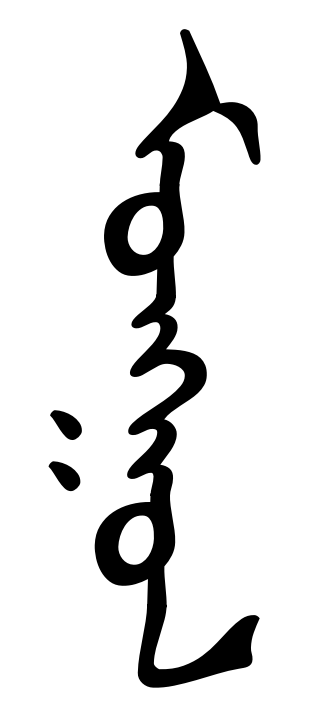


Боловсруулж байна (2/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Mongolian Writing'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Mongolian_Writing_2.png


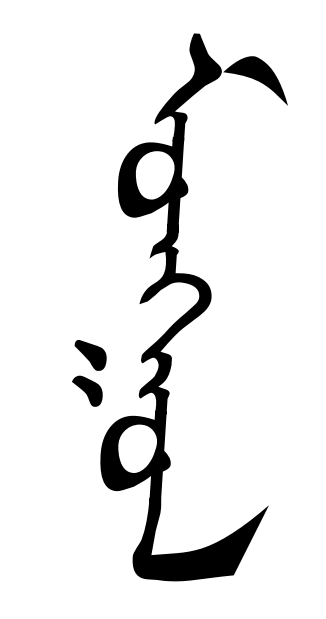


Боловсруулж байна (3/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Menk Hawang Tig'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Menk_Hawang_Tig_3.png


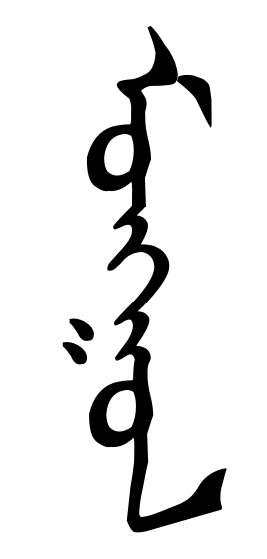


Боловсруулж байна (4/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Mongol Bichimel'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Mongol_Bichimel_4.png


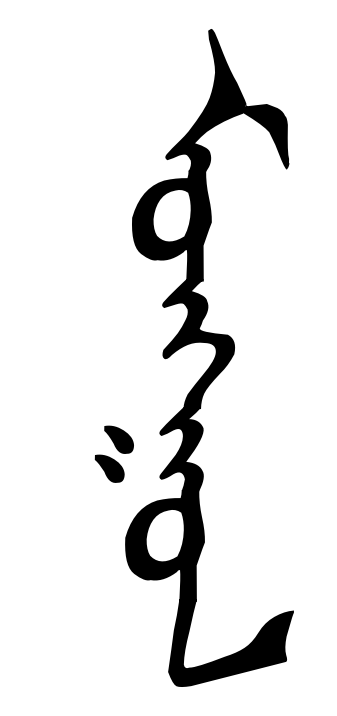


Боловсруулж байна (5/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Baga Chagan'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Baga_Chagan_5.png


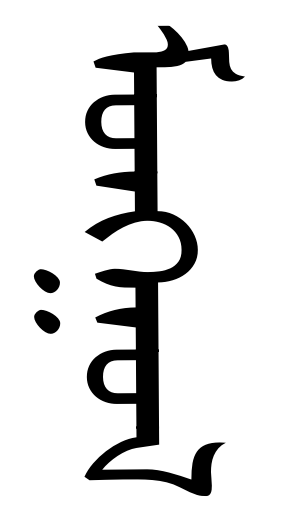


Боловсруулж байна (6/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Baga Garchag'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Baga_Garchag_6.png


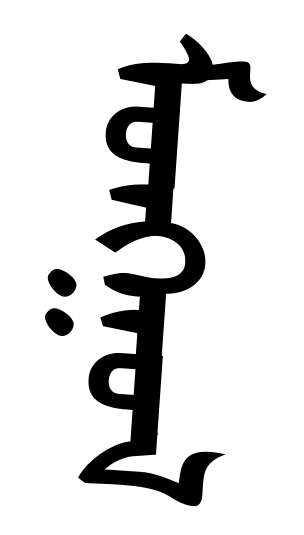


Боловсруулж байна (7/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Baga Syurga'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Baga_Syurga_7.png


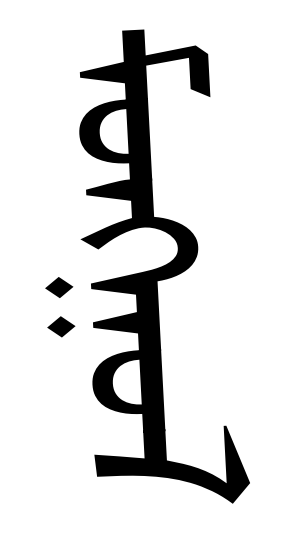


Боловсруулж байна (8/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Baga Urga'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Baga_Urga_8.png


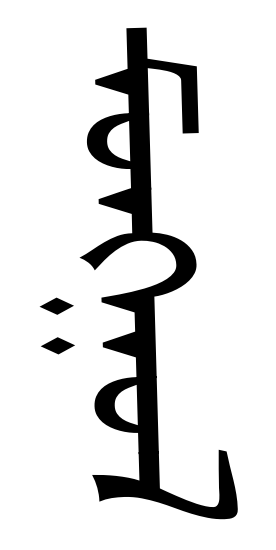


Боловсруулж байна (9/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Mongolian Baiti'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Mongolian_Baiti_9.png


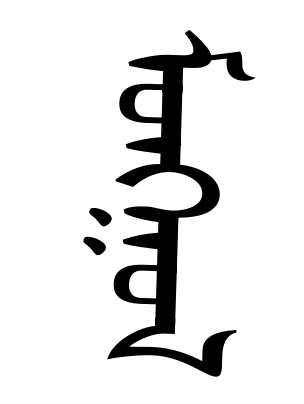


Боловсруулж байна (10/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Menk Qagan Tig'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Menk_Qagan_Tig_10.png


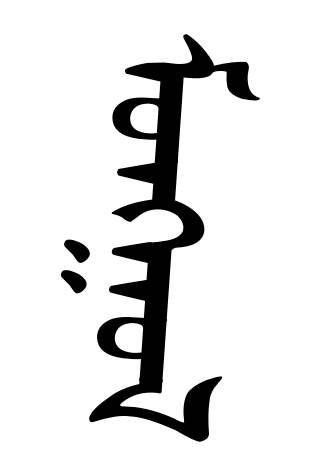


Боловсруулж байна (11/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Menk Scnin Tig'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Menk_Scnin_Tig_11.png


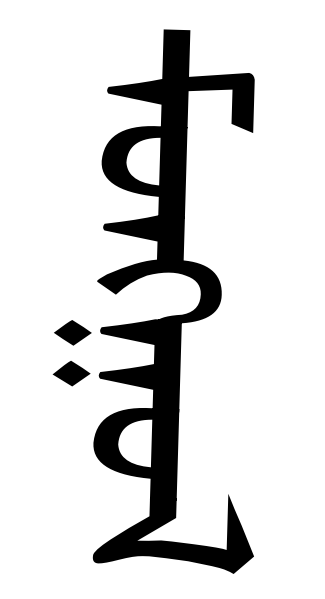


Боловсруулж байна (12/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Mongol Garchag'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Mongol_Garchag_12.png


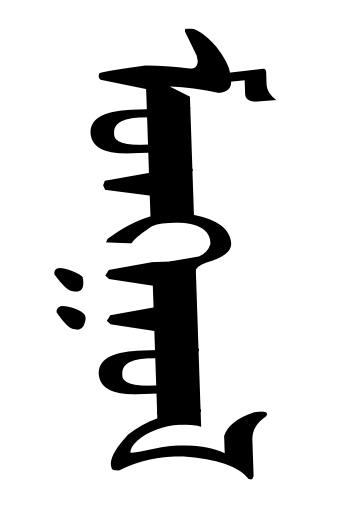


Боловсруулж байна (13/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Mongolian System'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Mongolian_System_13.png


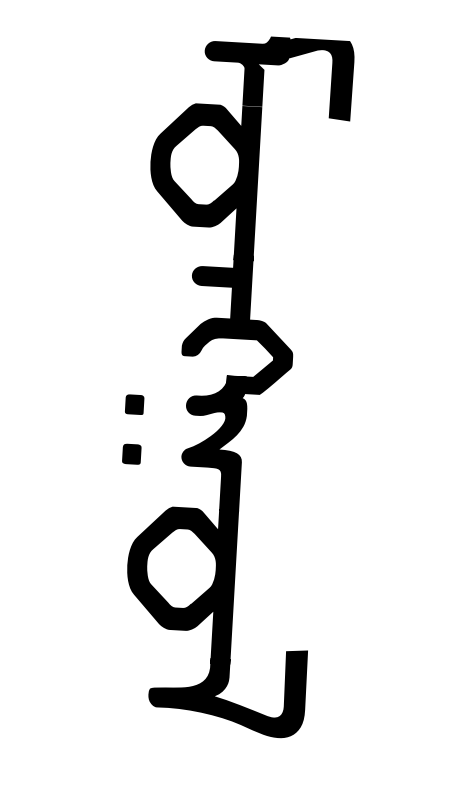


Боловсруулж байна (14/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Noto Sans Mongolian'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Noto_Sans_Mongolian_14.png


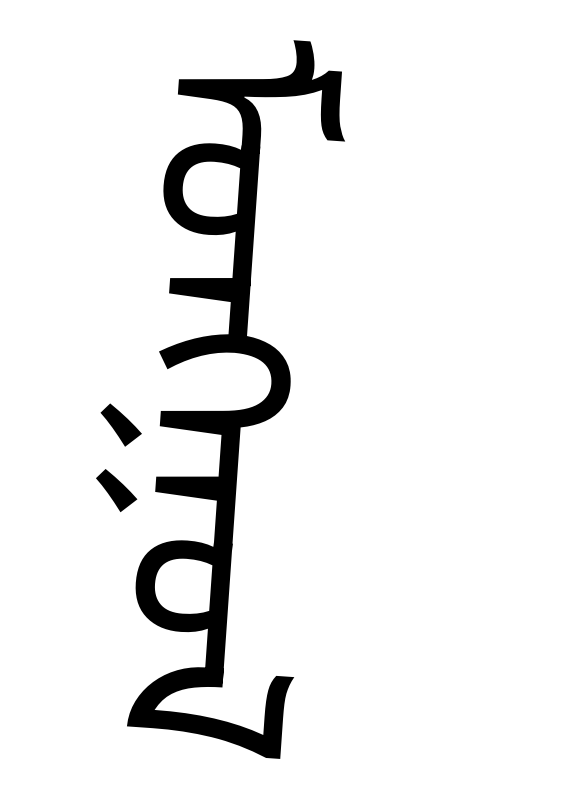


Боловсруулж байна (15/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Mongol Web'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Mongol_Web_15.png


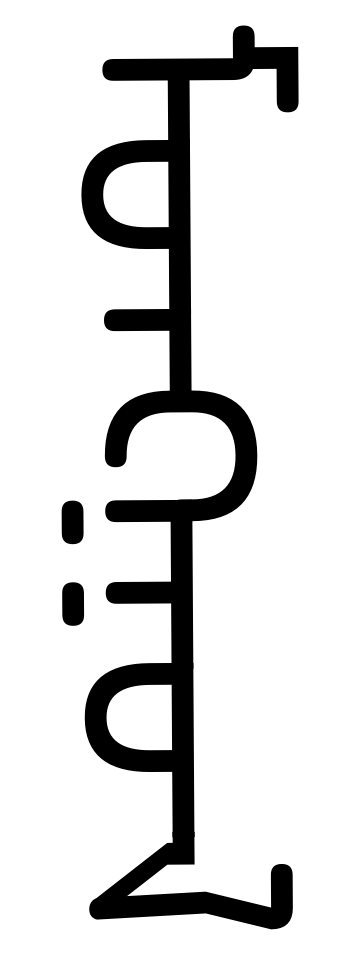


Боловсруулж байна (16/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Mongolian Title'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Mongolian_Title_16.png


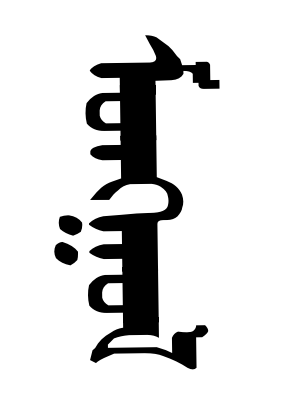


Боловсруулж байна (17/17): 'ᠮᠣᠩᠭᠣᠯ', фонт: 'Menk Garqag Tig'
  Зураг амжилттай хадгалагдлаа: c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images\mongol_word_Menk_Garqag_Tig_17.png


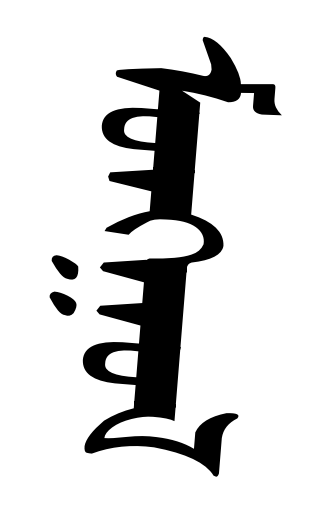


Нийт 17 зураг үүсгэгдлээ.
Зургууд 'c:\Users\domogdog\Desktop\bigproject\Mongol-tuulgatnii-hoyr-erhem-project-OCR-\munguu\generated_mongol_images' хавтсанд хадгалагдсан.


In [11]:
# Cell 4: Run the generation for all loaded fonts

# Эхлээд Cell 1, 2, 3-ыг дэс дараалан ажиллуулна уу.
# Дараа нь энэ cell-ийг ажиллуулна:
list_of_image_paths = run_generation_for_all_fonts()

if list_of_image_paths:
    print(f"\nНийт {len(list_of_image_paths)} зураг үүсгэгдлээ.")
    print(f"Зургууд '{os.path.join(os.getcwd(), IMAGES_SUBDIR_NAME)}' хавтсанд хадгалагдсан.")
else:
    print("\nЗураг үүсгэх явцад ямар ч зураг амжилттай үүсгэгдсэнгүй эсвэл алдаа гарлаа.")